# Atom Centered Symmetry Functions

ACSFs are a convenient way of transforming atomic coortinates and types into a computer-friendly string of numbers. Each atom gets its own set of ACSFs, computed using itself as the center, and all other atomic coordinates, which encode its chemical environment.<br>
<img src="https://github.com/reinimaurer1/ML-CSC-tutorial/blob/master/images/acsf-schema.png?raw=1" width="400px"><br>
The ACSFs are invariant under translation and rotations of the whole system, and independent on the ordering of the atoms.

The two main type of ACSFs are two- and three-body. Each set of ACSFs becomes the input of a neural network that calculates the corresponding energy contribution. The only important quantity is the total energy of the system, given by the sum of all contributions. All neural networks are fitted to minimise the error on total energy.

Derivatives of the energy w.r.t. atomic positions (forces) can be obtained analytically with the chain rule, and this makes ACSF the method of choice for molecular dynamics simulations.

For more info see: Jörg Behler, <i>J. Chem. Phys.</i> <b>134</b>, 074106 (2011)

## How it works

We are going to see ACSFs in action for a simple trimer system.

In [12]:
!pip install ase
!pip install nglview
# --- INITIAL DEFINITIONS ---
from sklearn.neural_network import MLPRegressor
import numpy, math, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ase.visualize import view
from ase import Atoms
import nglview

     |████████████████████████████████| 5.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nglview: filename=nglview-3.0.3-py3-none-any.whl size=8057549 sha256=3d1f4dead3888bf8d959e1770fa66144e3dd0aefb589c1e3fc2166b1009ca819
  Stored in directory: /root/.cache/pip/wheels/01/0c/49/c6f79d8edba8fe89752bf20de2d99040bfa57db0548975c5d5
Successfully built nglview


In [16]:
# parameters for the trimer
d1 = 1.0
d2 = 1.0
theta = 30
# convert angle to radians
theta *= math.pi/180

# generate the atomic coordinates
atoms = numpy.zeros((3,3))
atoms[1] = [math.cos(theta),-math.sin(theta),0]
atoms[2] = [-math.cos(theta),-math.sin(theta),0]
atoms = numpy.array(atoms)
atoms_sys = Atoms(positions=atoms, symbols=['H']*3)

# show the atomic position vectors - on rows
print(atoms)

# show atomic positions - drag mouse to rotate view
view(atoms_sys,viewer='x3d')

[[ 0.         0.         0.       ]
 [ 0.8660254 -0.5        0.       ]
 [-0.8660254 -0.5        0.       ]]


### Computing the ACSFs - two-body terms

The simplest ACSF quantifies the amount of atoms within cutoff:<br>
$$G^0_i = \sum_j f_c\left(r_{ij}\right)$$
with
$$f_c(r) = \frac{1}{2} \left[\cos\left(\pi \frac{r}{r_c}\right) + 1 \right]$$

In [17]:
# cutoff distance for all ACSFs
Rcut = 5.0

def fcut(r):
    return (math.cos(math.pi * r/Rcut)+1) * 0.5

# compute the ACSF G0 (sum of cutoff)
G0 = numpy.zeros(3)
for i in range(3): # compute one ACSF for each atom i
    for j in range(3): # loop over all OTHER atoms
        if i == j: continue
        r = numpy.linalg.norm(atoms[i]-atoms[j]) # compute distance i-j
        if r > Rcut: continue # skip if too far
        G0[i] += fcut(r)
        
print(G0)

[1.80901699 1.63651351 1.63651351]


The result is one number for each atom in the system. Larger values indicate more atoms in the vicinity. The last two atoms are a bit far from each other, thus their G0 is smaller than the central atom.

The next type of ACSF gives more information about distances to neighbouring atoms:


$$G^1_i = \sum_j e^{-\eta\left(r_{ij} - R_s \right)^2} f_c\left(r_{ij}\right)$$


where $\eta$ and $R_s$ are free parameters. The ACSF is a gaussian, and we can imagine that $G^1$ quantifies how many other atoms are found $R_s$ away from the central atom.<br>
In practice, $G^1$ is computed for several combinations of $\eta$ and $R_s$, thus each atom will have a series of $G^1$ values ($G^1$ is an array for each atom)

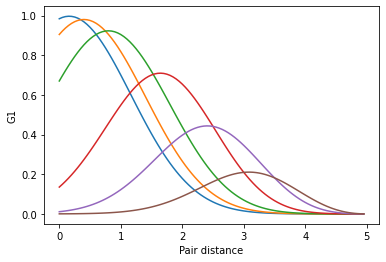

[[1.40043598 1.63686627 1.80901699 1.09722427 0.24482383 0.02009636]
 [0.98648228 1.21729202 1.49527923 1.25480542 0.45005989 0.06597201]
 [0.98648228 1.21729202 1.49527923 1.25480542 0.45005989 0.06597201]]


In [18]:
# G1 function definition
def G1f(x, eta, Rs):
     return math.exp(-eta*(x-Rs)*(x-Rs)) * ((math.cos(math.pi * x/Rcut)+1) * 0.5)
G1v = numpy.vectorize(G1f)

# this is a list of eta/Rs pairs to use in our example
p = [(0.4, 0.2),(0.4, 0.5),(0.4, 1.0),(0.5, 2.0),(0.5, 3.0),(0.5, 4.0)]

# make a nice plot of the ACSFs we are using
datar = numpy.arange(0, Rcut, Rcut/100)
for pp in p:
    plt.plot(datar, G1v(datar, pp[0], pp[1]) )
plt.xlabel('Pair distance')
plt.ylabel('G1')
plt.show()

# compute the ACSF G1
G1 = numpy.zeros((3, len(p)))

for i in range(3): # compute one ACSF for each atom i
    for j in range(3): # loop over all OTHER atoms
        if i == j: continue
        r = numpy.linalg.norm(atoms[i]-atoms[j]) # compute distance i-j
        if r > Rcut: continue # skip if too far
        
        for k in range(len(p)):
            eta, rs = p[k]
            G1[i,k] += G1f(r, eta, rs)
print(G1)

The result is a matrix: one row for each atom, one column for each pair or parameters $\eta$ and $R_s$.

### Three-body ACSF

A more complete description of the system can be achieved by adding ACSFs that depend on triplets of atoms, giving three-body terms to the energy expression. Usually they are functions of the cosine of the angle between three atoms, and the distances between them:


$$G^4_i = 2^{1-\zeta}\sum_{j,k} \left(1+\lambda\cos\left( \theta_{ijk} \right)\right)^\zeta \exp\left[-\eta\left(r_{ij}^2 +r_{ik}^2+r_{jk}^2\right)\right] f_c\left(r_{ij}\right)f_c\left(r_{ik}\right)f_c\left(r_{jk}\right)$$


where $\eta$, $\zeta$ and $\lambda$  are free parameter. Usually $\zeta$ is an integer and $\lambda = \pm 1$.

In [19]:
# G4 function definition
def G4f(cost, rij, rik, rjk, eta, zeta, lamb):
    result = math.pow(2,1-zeta) * math.pow(1+lamb*cost, zeta)
    result *= math.exp(-eta*(rij*rij + rik*rik + rjk*rjk))
    return result * fcut(rij) * fcut(rjk) * fcut(rik)


# this is a list of eta/zeta/lambda pairs to use in our example
p = [(0.4, 1, 1),(0.4, 2, 1),(0.4, 3, 1),(0.8, 1, 1),(0.8, 2, 1)]


# compute the ACSF G4
G4 = numpy.zeros((3, len(p)))

for i in range(3): # compute one ACSF for each atom i
    for j in range(3): # loop over all OTHER atoms
        if i == j: continue
        rij = numpy.linalg.norm(atoms[i]-atoms[j]) # compute distance i-j
        if rij > Rcut: continue # skip if too far
        for k in range(3):
            if k == i or k == j: continue
            rik = numpy.linalg.norm(atoms[i]-atoms[k]) # compute distance i-k
            rjk = numpy.linalg.norm(atoms[j]-atoms[k]) # compute distance j-k
            # compute cosine of angle
            cost = numpy.dot(atoms[i]-atoms[k],atoms[i]-atoms[j])
            cost /= rij * rik
            
            for k in range(len(p)):
                eta, zeta, lamb = p[k]
                G4[i,k] += G4f(cost,rij,rik,rjk, eta, zeta, lamb)
print(G4)

[[0.08104951 0.02026238 0.00506559 0.01096886 0.00274221]
 [0.30248089 0.28221851 0.26331345 0.04093634 0.03819412]
 [0.30248089 0.28221851 0.26331345 0.04093634 0.03819412]]


### Remarks

These are some of the functions suggested by the authors, but more can be crafted. Two-body ACSFs must only depend on the pair distance, while three-body ones must include angular dependence.

In practice ACSFs are subdivided according to the atomic types. For example, if the system only has C and H, each atom $i$ of type C will have two sets of $G^1$:

$$G^1_{i-C} = \sum_{j\in C} e^{-\eta\left(r_{ij} - R_s \right)^2} f_c\left(r_{ij}\right)$$
$$G^1_{i-H} = \sum_{j\in H} e^{-\eta\left(r_{ij} - R_s \right)^2} f_c\left(r_{ij}\right)$$

and similarly for three-body ACSFs. The chemical environments w.r.t. different atomic species are separate, and go to different neural networks. This way, more information is retained in the ACSF descriptors but more NN parameters will be necessary to accurately model the system, and more training data has to be supplied.

## Exercises

### 1. Invariants
Verify (numerically) that the ACSF are invariant under translations and rotations of the whole system.

### 2. Smoothness
Verify (numerically) that ACSF change smoothly for small changes in the system

### 3. A new ACSF
Implement the $G^5$ three-body ACSF:

$$G^5_i = 2^{1-\zeta}\sum_{j,k} \left(1+\lambda\cos\left( \theta_{ijk} \right)\right)^\zeta \exp\left[-\eta\left(r_{ij}^2 +r_{ik}^2\right)\right] f_c\left(r_{ij}\right)f_c\left(r_{ik}\right)$$